In [21]:
import pymongo, pandas as pd, numpy as np, re, sklearn, nltk

# Fifth Hypothesis:

In the following notebook it will be analyzed the following hypotesis:
 - **Does there exist a relationship between the text of the review and the number of *votes up* that it receives? Can we predict this value with a Machine Learning model?**

## Correlation between the text of the review and the votes up

We want to start with an easy model that just considers the text of the review and the votes up, in order to understand if there is a correlation between those two features. <br>
If the overall accuracy of that simple model is good enough we'll stop considering it as the optimal one, otherwise we'll add new reasonable features to the model in order to increase the obtained performances.

### Import json reviews dataset & select relevant features to perform the analysis

In [2]:
# Connect to the mongo local and load as a dataframe the small_reviews collection
mongo = pymongo.MongoClient()
mongo_db = mongo.final_project
small_reviews_df = pd.DataFrame(list(mongo_db.small_reviews.find({}, {'_id': False})))
mongo.close() #Close the connection

In [3]:
# Select only the useful data to perform the analysis
df = small_reviews_df[['review', 'votes_up']]
df

,review,votes_up
0,good\n,0
1,"I beat this game 5 times on ps3, when i saw th...",0
2,one of the best 3rd person shooting game,0
3,I enjoy the game. Played it to 100% on PS3 an...,0
4,me cague a tiro con brazucas y me empastille a...,0
...,...,...
308519,Excuse me kind programmer this game isnt worki...,2
308520,"Really fun, great game design. I like the char...",1
308521,"I just bought this game, I like it, it has a l...",1
308522,Age of Rivals is a really interesting card gam...,4


### Remove empty text reviews

In [4]:
# It looks like some written reviews are empty...
print(df[df['review'].isna() == True])

       review  votes_up
289      None         0
1016     None         0
1420     None         0
1920     None         0
2132     None         0
...       ...       ...
304378   None         0
304422   None         0
305249   None         0
305271   None         0
305504   None         0

[440 rows x 2 columns]


In [5]:
# Remove NaN elements in dataframe
df = df.dropna()

### Divide reviews in two classes: useful & not useful

Since this hypothesis can be used by Steam in order to display, for users that are interested on buying a new game, only the potential useful reviews (the ones having more than N votes up) the idea is to consider only useful and not useful reviews and build a model that is capable of recognizing those two classes. <br>
Since we do not want our model to be biased towards one of the two classes, we'll consider the same number of samples for the two different classes (useful/not useful review).<br>
For us a good review is when its associated *votes_up* has a value greater than the M percentile of the overall *votes_up* distribution.

In [6]:
votes_up_for_useful_review = np.percentile(df['votes_up'], 99)
votes_up_for_useful_review

32.0

In [7]:
useful_review_df = df[df['votes_up'] >= votes_up_for_useful_review]
not_useful_review_df = df[df['votes_up'] < votes_up_for_useful_review].sample(n=len(useful_review_df), random_state=0)
restricted_df = pd.concat([useful_review_df, not_useful_review_df])
restricted_df = restricted_df.sample(frac=1) # shuffling
restricted_df

,review,votes_up
243795,Watch Dogs 1: No\nWatch Dogs 2: Yes\n\nThat's ...,40
130477,[h1]Review: Batman Arkham Asylum GOTY [/h1]\n...,34
187363,Perfect boosted my fps on csgo with a slightly...,50
52687,"haha, car goes brrrrrrr",87
65310,"If you have Windows 10, you need to go to stea...",34
...,...,...
181329,"I really wanted to like this game, but in the ...",37
24323,You've heard all those stories in school about...,37
97477,OK I played the old version and own the new ve...,0
15524,This is a scam.,8


In [8]:
# Replace the output label with a 1 (so a good review) if the review's votes up are greater than threshold, 0 otherwise
y = np.array(restricted_df['votes_up'].apply(lambda x: 0 if x < votes_up_for_useful_review else 1))

### Obtain the Bag-Of-Words and predict, using the review text, the votes_up values

In [9]:
# Define the vectorizer object that applies stemming and removes english stop words to input documents
CountVectorizer = sklearn.feature_extraction.text.CountVectorizer
stemmer = nltk.stem.PorterStemmer()
analyzer = CountVectorizer(stop_words='english').build_analyzer()
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

# This function instead is used in order to remove not characters in written reviews
def remove_not_characters(input):
    return ''.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, list(input))))

In [10]:
# Remove to all the documents the not characters
docs = np.array(restricted_df['review'].apply(lambda x: remove_not_characters(x)))
# Build the vectorizer
stem_vectorizer = CountVectorizer(analyzer=stemmed_words)
# Fit the bag-of-words model
bow = stem_vectorizer.fit_transform(docs)

In [11]:
# Obtain input
X = bow.toarray()

# Create training and test split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.9, shuffle=True, random_state=0)

### Models


#### Logistic Regression

In [12]:
# Create an instance of LogisticRegression classifier
lr = sklearn.linear_model.LogisticRegression(C=100.0, random_state=0, solver='liblinear', multi_class='ovr')
# Fit the model
lr.fit(X_train, y_train)
# Create the predictions
lr_y_predict = lr.predict(X_test)
# Use metrics.accuracy_score to measure the score
print("Logistic Regression accuracy: %.2f" % (sklearn.metrics.accuracy_score(y_test, lr_y_predict) * 100))

Logistic Regression accuracy: 67.09


#### Support Vector Machine

In [13]:
# Create an instance of SVM classifier
svm = sklearn.svm.SVC(random_state=0)
# Fit the model
svm.fit(X_train, y_train)
# Create the predictions
svm_y_predict = svm.predict(X_test)
# Use metrics.accuracy_score to measure the score
print("SVM accuracy: %.2f" % (sklearn.metrics.accuracy_score(y_test, svm_y_predict) * 100))

SVM accuracy: 70.47


Those results show (no matter the model) that there is a correlation between the text of the review and the *votes_up* label, otherwise the accuracy of our model would have been of the 50% (randomly picking one class). <br>

### Confusion matrix, using the best simple model

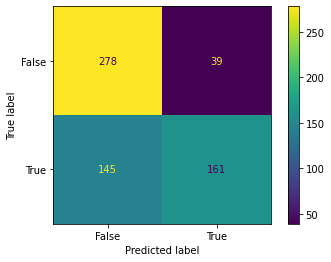

In [22]:
lr_acc = sklearn.metrics.accuracy_score(y_test, lr_y_predict)
svm_acc = sklearn.metrics.accuracy_score(y_test, svm_y_predict)

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, svm_y_predict if svm_acc > lr_acc else lr_y_predict)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot();

### Add new features to the simple model (that just uses reviews' text), to improve predictions 

Can we increase the accuracy of our model by adding new suited features to the model's input?